<a href="https://colab.research.google.com/github/chdmitr2/Deep-Learning-22961/blob/main/maman12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Maman 12**

**Dmitriy Chudnovsky 324793900**

**Question 1**

**Part A** **implements the my_sampler(size, dist, requires_grad=False) function** **that:**    

*  Checks that all probabilities in dist are positive and sum to 1.
*   Samples discretely from that distribution to produce a tensor of shape size.
*   Uses only one loop that begins exactly with for i in range(len(dist)-1):.

In [4]:
import torch
import matplotlib.pyplot as plt


def my_sampler(size, dist, requires_grad=False):
    # Convert size to tuple if it is an integer
    if isinstance(size, int):
        size = (size,)

    # Convert dist to tensor if it's a list
    if not isinstance(dist, torch.Tensor):
        dist = torch.tensor(dist, dtype=torch.float)

    # Validation checks
    assert (dist > 0).all(), "All probabilities must be positive."
    assert torch.allclose(dist.sum(), torch.tensor(1.0)), "Probabilities must sum to 1."

    with torch.no_grad():
        # Compute cumulative distribution
        cdist = torch.cumsum(dist, dim=0)

        # Sample uniform random values in the given shape
        U = torch.rand(size)

        # Initialize samples with -1
        samples = torch.full(size, -1, dtype=torch.long)

        # Assign categories using a single loop
        for i in range(len(dist) - 1):
            mask = (samples == -1) & (U < cdist[i])
            samples[mask] = i

        # Remaining values are assigned to the last category
        samples[samples == -1] = len(dist) - 1

    # Convert to float for gradient support
    samples = samples.to(torch.float)
    samples.requires_grad_(requires_grad)
    return samples

# Example usage:

print(my_sampler(10,[0.5,0.5]))
A=my_sampler((2,8),[0.1,0.2,0.7],requires_grad=True)
print(A,A.grad,sep='\n')


tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([[1., 2., 2., 2., 2., 2., 2., 0.],
        [2., 2., 2., 2., 1., 2., 1., 1.]], requires_grad=True)
None


**Part B: Drawing Samples and Plotting**

Below is an example of drawing 10,000 samples from the distribution [0.7, 0.2, 0.1] and showing a histogram via matplotlib.

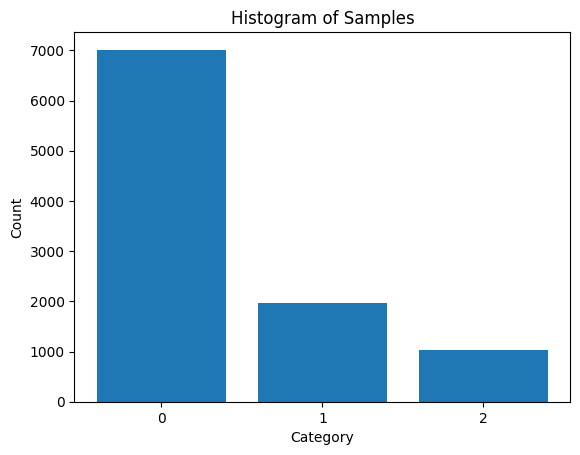

In [5]:

# Example usage:

samples = my_sampler(10_000, [0.7, 0.2, 0.1])
plt.hist(samples.numpy(), bins=[-0.5, 0.5, 1.5, 2.5], rwidth=0.8)
plt.xticks([0, 1, 2])
plt.title("Histogram of Samples")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


**Question 2**

We create a new MyScalar by calling one of the functions (add, mul, power, exp, etc.), we record:

1.   The numeric value of the new scalar.
2.   The partial derivatives with respect to the input(s).
3.   Which MyScalar(s) it came from (the “parents”).

In [6]:
import math

class MyScalar:
    def __init__(self, value):
        self.value = float(value)  # store as float
        self.grad = 0.0
        self.parent = None
        self.local_grad_wrt_parent = 0.0

    def __repr__(self):
        return f"MyScalar(value={self.value}, grad={self.grad})"

def add(a, b):
    if isinstance(b, MyScalar):
        raise NotImplementedError("For single-input AD, we only implement a + constant.")
    c_value = a.value + b
    c = MyScalar(c_value)
    c.parent = a
    c.local_grad_wrt_parent = 1.0
    return c

def mul(a, b):
    if isinstance(b, MyScalar):
        raise NotImplementedError("For single-input AD, we only implement a * constant.")
    c_value = a.value * b
    c = MyScalar(c_value)
    c.parent = a
    c.local_grad_wrt_parent = b
    return c

def power(a, exponent):
    c_value = a.value ** exponent
    c = MyScalar(c_value)
    # derivative wrt a is exponent * a^(exponent-1)
    c.parent = a
    c.local_grad_wrt_parent = exponent * (a.value ** (exponent - 1))
    return c

def sin(a):
    c_value = math.sin(a.value)
    c = MyScalar(c_value)
    c.parent = a
    c.local_grad_wrt_parent = math.cos(a.value)
    return c

def cos(a):
    c_value = math.cos(a.value)
    c = MyScalar(c_value)
    c.parent = a
    c.local_grad_wrt_parent = -math.sin(a.value)
    return c

def ln(a):
    c_value = math.log(a.value)
    c = MyScalar(c_value)
    c.parent = a
    c.local_grad_wrt_parent = 1.0 / a.value
    return c

def exp(a):
    c_value = math.exp(a.value)
    c = MyScalar(c_value)
    c.parent = a
    # local grad wrt a is e^(a.value) = c.value
    c.local_grad_wrt_parent = c.value
    return c

A call to get_gradient(final_scalar) will then:

*   Reset all .grad to 0 in the relevant subgraph.
*   Set final_scalar.grad = 1.0.
*   Propagate backward using the chain rule to all ancestors, summing up their gradients.
*    Return a dictionary of [scalar -> scalar.grad].

In [7]:
def get_gradient(final_scalar):
    """
    Single-parent chain AD:
    We do one pass back through the parents to accumulate the gradients.
    """

    # Gather all ancestors by following .parent
    visited = []
    stack = [final_scalar]
    while stack:
        node = stack.pop()
        if node not in visited:
            visited.append(node)
            if node.parent is not None:
                stack.append(node.parent)

    # Zero all .grad
    for n in visited:
        n.grad = 0.0

    # final node’s gradient is 1
    final_scalar.grad = 1.0

    # Walk back from final_scalar up to the root
    cur = final_scalar
    while cur.parent is not None:
        p = cur.parent
        p.grad += cur.grad * cur.local_grad_wrt_parent
        cur = p

    return {n: n.grad for n in visited}

# Example usage
a = MyScalar(2)     # a = 2
b = power(a, 2)     # b = a^2
c = exp(b)          # c = e^(b)
grads = get_gradient(c)

print("a =", a)
print("b =", b)
print("c =", c)
print("Gradients:")
for node, val in grads.items():
    print(node, val)

# Expected:
# grads[a] = e^(a^2)*2a   --> e^4 * (2*2) = e^4 * 4
# grads[b] = e^(b)       --> e^4
# grads[c] = 1

a = MyScalar(value=2.0, grad=218.39260013257694)
b = MyScalar(value=4.0, grad=54.598150033144236)
c = MyScalar(value=54.598150033144236, grad=1.0)
Gradients:
MyScalar(value=54.598150033144236, grad=1.0) 1.0
MyScalar(value=4.0, grad=54.598150033144236) 54.598150033144236
MyScalar(value=2.0, grad=218.39260013257694) 218.39260013257694
